# Testing some configs

In [5]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [6]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data.dropna(), bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(data.dropna())
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


In [7]:


# Query to get equipment values for both teams per round
query = """
SELECT 
    r.id,
	r.match_id,
    r.id_demo_exports,
	r.round_num,
    r.ct_winner,
    r.team1_winner,
    r.is_ct_t1,
    r.round_end_reason,
    -- CT team equipment
    SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
    -- T team equipment
    SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
    -- Higher and lower equipment
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as higher_equipment,
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) <= 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as lower_equipment,
    -- Did the higher equipment team win?
    CASE 
        WHEN (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
              SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND r.ct_winner)
        OR (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) < 
            SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND NOT r.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won
FROM rounds_ed r
JOIN player_round_ed pr ON r.id = pr.round_id 
WHERE pr.eq_val_fte > 0  -- Valid equipment values
GROUP BY 1,2,3,4,5,6,7,8
HAVING SUM(CASE WHEN pr.team = 1 THEN pr.eq_val_fte ELSE 0 END) > 0
   AND SUM(CASE WHEN pr.team = 2 THEN pr.eq_val_fte ELSE 0 END) > 0
ORDER BY 1,2,3,4
"""

print("📊 Fetching equipment data from database...")
equipment_df = pd.read_sql_query(query, conn)
print(f"✅ Loaded {len(equipment_df):,} rounds")
print(f"   Matches: {equipment_df['match_id'].nunique():,}")
print(f"   Demos: {equipment_df['id_demo_exports'].nunique():,}")
print()

# Display sample data
print("Sample data:")
print(equipment_df.head(10))
print()
print("Data summary:")
print(equipment_df.describe())

📊 Fetching equipment data from database...


C:\Users\peter\AppData\Local\Temp\ipykernel_21340\701649246.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  equipment_df = pd.read_sql_query(query, conn)


✅ Loaded 2,601,592 rounds
   Matches: 53,582
   Demos: 98,937

Sample data:
     id  match_id  id_demo_exports  round_num  ct_winner  team1_winner  \
0  5891   2366874              184          1       True         False   
1  5892   2366874              184          2       True         False   
2  5893   2366874              184          3       True         False   
3  5894   2366874              184          4      False          True   
4  5895   2366874              184          5      False          True   
5  5896   2366874              184          6      False          True   
6  5897   2366874              184          7      False          True   
7  5898   2366874              184          8      False          True   
8  5899   2366874              184          9       True         False   
9  5900   2366874              184         10      False          True   

   is_ct_t1  round_end_reason  ct_equipment  t_equipment  higher_equipment  \
0     False                 8  

# Calculate r-value using the formula

We'll calculate r by grouping rounds by equipment ratio, then computing average win rates:

$$r = \frac{\ln\left(\frac{1-p}{p}\right)}{\ln\left(\frac{y}{x}\right)}$$

Where:
- $x$ = **Higher equipment value** (the team with more equipment)
- $y$ = **Lower equipment value** (the team with less equipment)
- $p$ = **Probability that the higher equipment team wins** (average win rate for higher equipment at a given ratio)

Method:
1. Group rounds by ratio y/x (lower/higher equipment)
2. Calculate average win rate (p) for the higher equipment team at each ratio
3. Compute r for each ratio group using the formula above

Total unique ratios (rounded): 99
Valid r calculations: 99
Total rounds analyzed: 2,601,592

R-VALUE SUMMARY STATISTICS
Mean r:     -9.9787
Median r:   1.0932
Std Dev:    110.4732
Min r:      -1098.0606
Max r:      5.5422
Q1 (25%):   1.0487
Q3 (75%):   1.1293

Weighted Mean r (by round count):   -15.0697
Weighted Median r (by round count): 1.0801

R-value Distribution (Percentiles):
   5th percentile: 0.8502
  10th percentile: 0.9718
  25th percentile: 1.0487
  50th percentile: 1.0932
  75th percentile: 1.1293
  90th percentile: 1.1940
  95th percentile: 1.2196

DETAILED RESULTS BY RATIO (y/x = Lower/Higher Equipment)
   Ratio | Higher Win% |  Rounds |  r-value |  Avg High $ |  Avg Low $
--------------------------------------------------------------------------------
   0.024 |     100.00% |       2 |   5.5422 |       33650 |        800
   0.033 |      94.75% |   10181 |   0.8459 |       30883 |       1010
   0.040 |      96.52% |   44689 |   1.0319 |       26756 |       1067
   0.050 

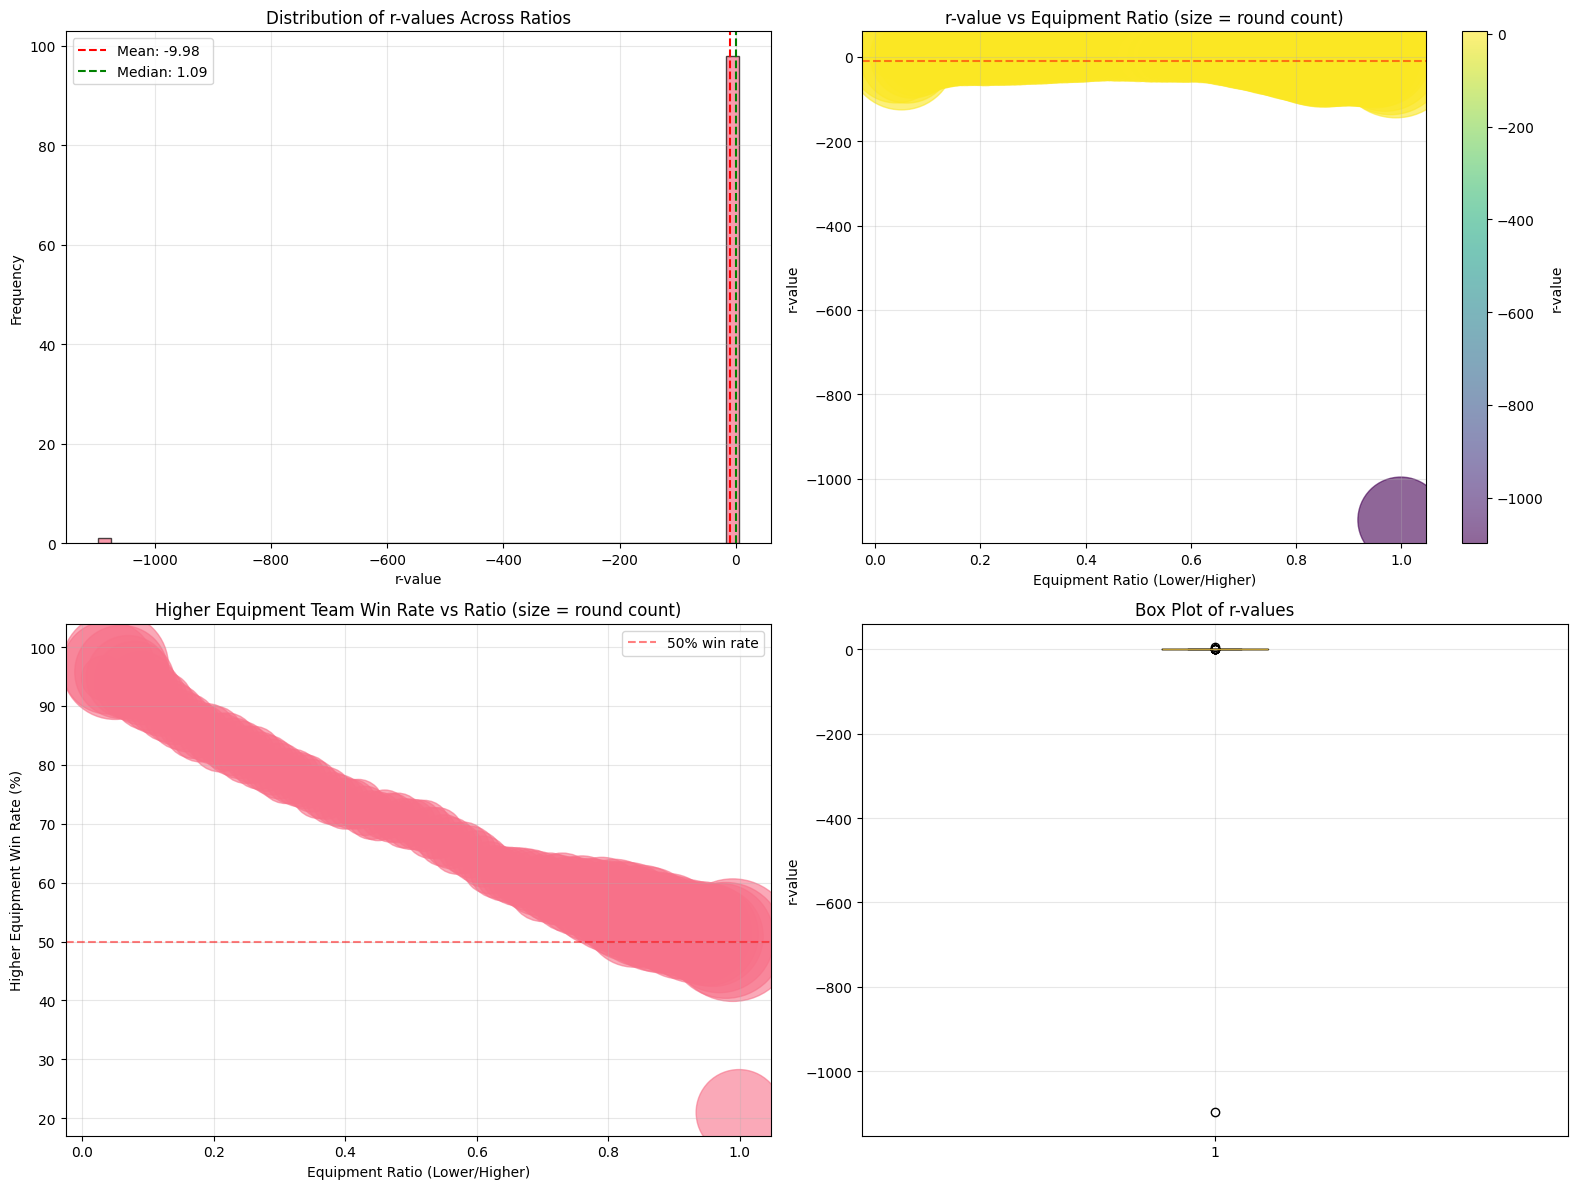

✅ Results stored in 'ratio_analysis' DataFrame
   Use ratio_analysis.head() to view top rows


In [ ]:
# Calculate r-value by grouping rounds by equipment ratio y/x
# where x = higher equipment, y = lower equipment, p = higher equipment win rate
import numpy as np
import pandas as pd

# Prepare data
df = equipment_df.copy()
df = df[(df['ct_equipment'] > 0) & (df['t_equipment'] > 0)].copy()

# Determine higher and lower equipment for each round
df['x'] = df['higher_equipment'].astype(float)  # Higher equipment
df['y'] = df['lower_equipment'].astype(float)  # Lower equipment

# Determine if higher equipment team won (p)
df['higher_equipment_won'] = df['higher_equipment_won'].astype(int)

# Calculate ratio y/x (lower/higher)
df['ratio_y_x'] = df['y'] / df['x']

# Round ratio to 2 decimals for grouping
df['ratio_rounded'] = np.round(df['ratio_y_x'], 2)

# Group by rounded ratio and calculate average higher equipment win rate (p)
ratio_stats = df.groupby('ratio_rounded').agg({
    'higher_equipment_won': ['mean', 'count'],  # mean is the average win rate (p) for higher equipment team
    'x': 'mean',
    'y': 'mean',
    'ratio_y_x': 'mean'
}).reset_index()

# Flatten column names
ratio_stats.columns = ['ratio_rounded', 'p', 'count', 'x_mean', 'y_mean', 'ratio_mean']

# Calculate r for each ratio group using: r = ln((1-p)/p) / ln(y/x)
def calculate_r_from_p_and_ratio(p, ratio):
    """Calculate r given average win rate p and ratio y/x"""
    epsilon = 1e-9
    
    # Avoid edge cases
    if p <= 0 or p >= 1:
        p = np.clip(p, epsilon, 1 - epsilon)
    
    if ratio <= 0:
        return np.nan
    
    numerator = np.log((1 - p) / p)
    denominator = np.log(ratio)
    
    if abs(denominator) < epsilon:
        return np.nan
    
    return numerator / denominator

ratio_stats['r'] = ratio_stats.apply(
    lambda row: calculate_r_from_p_and_ratio(row['p'], row['ratio_mean']), 
    axis=1
)

# Filter out invalid r values
ratio_stats_valid = ratio_stats[np.isfinite(ratio_stats['r'])].copy()

# Sort by ratio
ratio_stats_valid = ratio_stats_valid.sort_values('ratio_mean')

print(f"Total unique ratios (rounded): {len(ratio_stats):,}")
print(f"Valid r calculations: {len(ratio_stats_valid):,}")
print(f"Total rounds analyzed: {df['higher_eq_won'].count():,}")
print()

# Summary statistics for r values
print("=" * 70)
print("R-VALUE SUMMARY STATISTICS")
print("=" * 70)
print(f"Mean r:     {ratio_stats_valid['r'].mean():.4f}")
print(f"Median r:   {ratio_stats_valid['r'].median():.4f}")
print(f"Std Dev:    {ratio_stats_valid['r'].std():.4f}")
print(f"Min r:      {ratio_stats_valid['r'].min():.4f}")
print(f"Max r:      {ratio_stats_valid['r'].max():.4f}")
print(f"Q1 (25%):   {ratio_stats_valid['r'].quantile(0.25):.4f}")
print(f"Q3 (75%):   {ratio_stats_valid['r'].quantile(0.75):.4f}")
print()

# Weighted statistics (by count of rounds in each ratio)
weighted_r_mean = np.average(ratio_stats_valid['r'], weights=ratio_stats_valid['count'])
weighted_r_median = np.median(np.repeat(ratio_stats_valid['r'].values, ratio_stats_valid['count'].astype(int)))
print(f"Weighted Mean r (by round count):   {weighted_r_mean:.4f}")
print(f"Weighted Median r (by round count): {weighted_r_median:.4f}")
print()

# Percentiles
print("R-value Distribution (Percentiles):")
for pct in [5, 10, 25, 50, 75, 90, 95]:
    print(f"  {pct:2d}th percentile: {ratio_stats_valid['r'].quantile(pct/100):.4f}")
print()

# Display detailed results ordered by ratio
print("=" * 80)
print("DETAILED RESULTS BY RATIO (y/x = Lower/Higher Equipment)")
print("=" * 80)
print(f"{'Ratio':>8} | {'Higher Win%':>11} | {'Rounds':>7} | {'r-value':>8} | {'Avg High $':>11} | {'Avg Low $':>10}")
print("-" * 80)

for idx, row in ratio_stats_valid.iterrows():
    print(f"{row['ratio_mean']:8.3f} | {row['p']*100:10.2f}% | {row['count']:7.0f} | {row['r']:8.4f} | {row['x_mean']:11.0f} | {row['y_mean']:10.0f}")

print("=" * 80)
print()

# Show top and bottom ratios by r-value
print("Top 10 Highest r-values:")
print(ratio_stats_valid.nlargest(10, 'r')[['ratio_mean', 'p', 'count', 'r']])
print()

print("Top 10 Lowest r-values:")
print(ratio_stats_valid.nsmallest(10, 'r')[['ratio_mean', 'p', 'count', 'r']])
print()

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. R-value distribution histogram
ax1.hist(ratio_stats_valid['r'], bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(ratio_stats_valid['r'].mean(), color='red', linestyle='--', 
            label=f'Mean: {ratio_stats_valid["r"].mean():.2f}')
ax1.axvline(ratio_stats_valid['r'].median(), color='green', linestyle='--', 
            label=f'Median: {ratio_stats_valid["r"].median():.2f}')
ax1.set_xlabel('r-value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of r-values Across Ratios')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. R-value vs Ratio scatter plot
scatter = ax2.scatter(ratio_stats_valid['ratio_mean'], ratio_stats_valid['r'], 
                      s=ratio_stats_valid['count']/10, alpha=0.6, c=ratio_stats_valid['r'],
                      cmap='viridis')
ax2.set_xlabel('Equipment Ratio (Lower/Higher)')
ax2.set_ylabel('r-value')
ax2.set_title('r-value vs Equipment Ratio (size = round count)')
ax2.axhline(ratio_stats_valid['r'].mean(), color='red', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='r-value')

# 3. Higher Equipment Win Rate vs Ratio
ax3.scatter(ratio_stats_valid['ratio_mean'], ratio_stats_valid['p']*100, 
            s=ratio_stats_valid['count']/10, alpha=0.6)
ax3.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% win rate')
ax3.set_xlabel('Equipment Ratio (Lower/Higher)')
ax3.set_ylabel('Higher Equipment Win Rate (%)')
ax3.set_title('Higher Equipment Team Win Rate vs Ratio (size = round count)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plot of r-values
ax4.boxplot(ratio_stats_valid['r'], vert=True)
ax4.set_ylabel('r-value')
ax4.set_title('Box Plot of r-values')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for further analysis
ratio_analysis = ratio_stats_valid.copy()
print(f"✅ Results stored in 'ratio_analysis' DataFrame")
print(f"   Use ratio_analysis.head() to view top rows")

# Alternative Methods for Estimating r

We'll now estimate the parameter `r` in the Contest Success Function using multiple statistical methods:

$$P(\text{CT win}) = \frac{x^r}{x^r + y^r}$$

Methods to compare:
1. **Maximum Likelihood Estimation (MLE)** - Standard approach
2. **Nonlinear Least Squares (NLS)** - Minimize squared prediction errors
3. **Bayesian Estimation** - Posterior distribution with prior
4. **Bootstrap Confidence Intervals** - Resampling-based uncertainty quantification

Each method provides different perspectives on parameter uncertainty and robustness.

Dataset: 2,601,592 rounds
CT wins: 1,339,476 (51.49%)

METHOD 1: MAXIMUM LIKELIHOOD ESTIMATION (MLE)
MLE estimate: r = 1.0855
Optimization success: True
Negative log-likelihood: 1514257.48

METHOD 2: NONLINEAR LEAST SQUARES (NLS)
MLE estimate: r = 1.0855
Optimization success: True
Negative log-likelihood: 1514257.48

METHOD 2: NONLINEAR LEAST SQUARES (NLS)
NLS estimate: r = 1.0986
Optimization success: True
Residual sum of squares: 524628.86

METHOD 3: BAYESIAN ESTIMATION (Maximum A Posteriori)
NLS estimate: r = 1.0986
Optimization success: True
Residual sum of squares: 524628.86

METHOD 3: BAYESIAN ESTIMATION (Maximum A Posteriori)
Bayesian MAP estimate: r = 1.0855
Prior: Beta(2, 2) scaled to [0, 5]
Optimization success: True
Negative log posterior: 1514259.25

METHOD 4: BOOTSTRAP CONFIDENCE INTERVALS
Running 1000 bootstrap iterations...
Bayesian MAP estimate: r = 1.0855
Prior: Beta(2, 2) scaled to [0, 5]
Optimization success: True
Negative log posterior: 1514259.25

METHOD 4: BOOTSTR

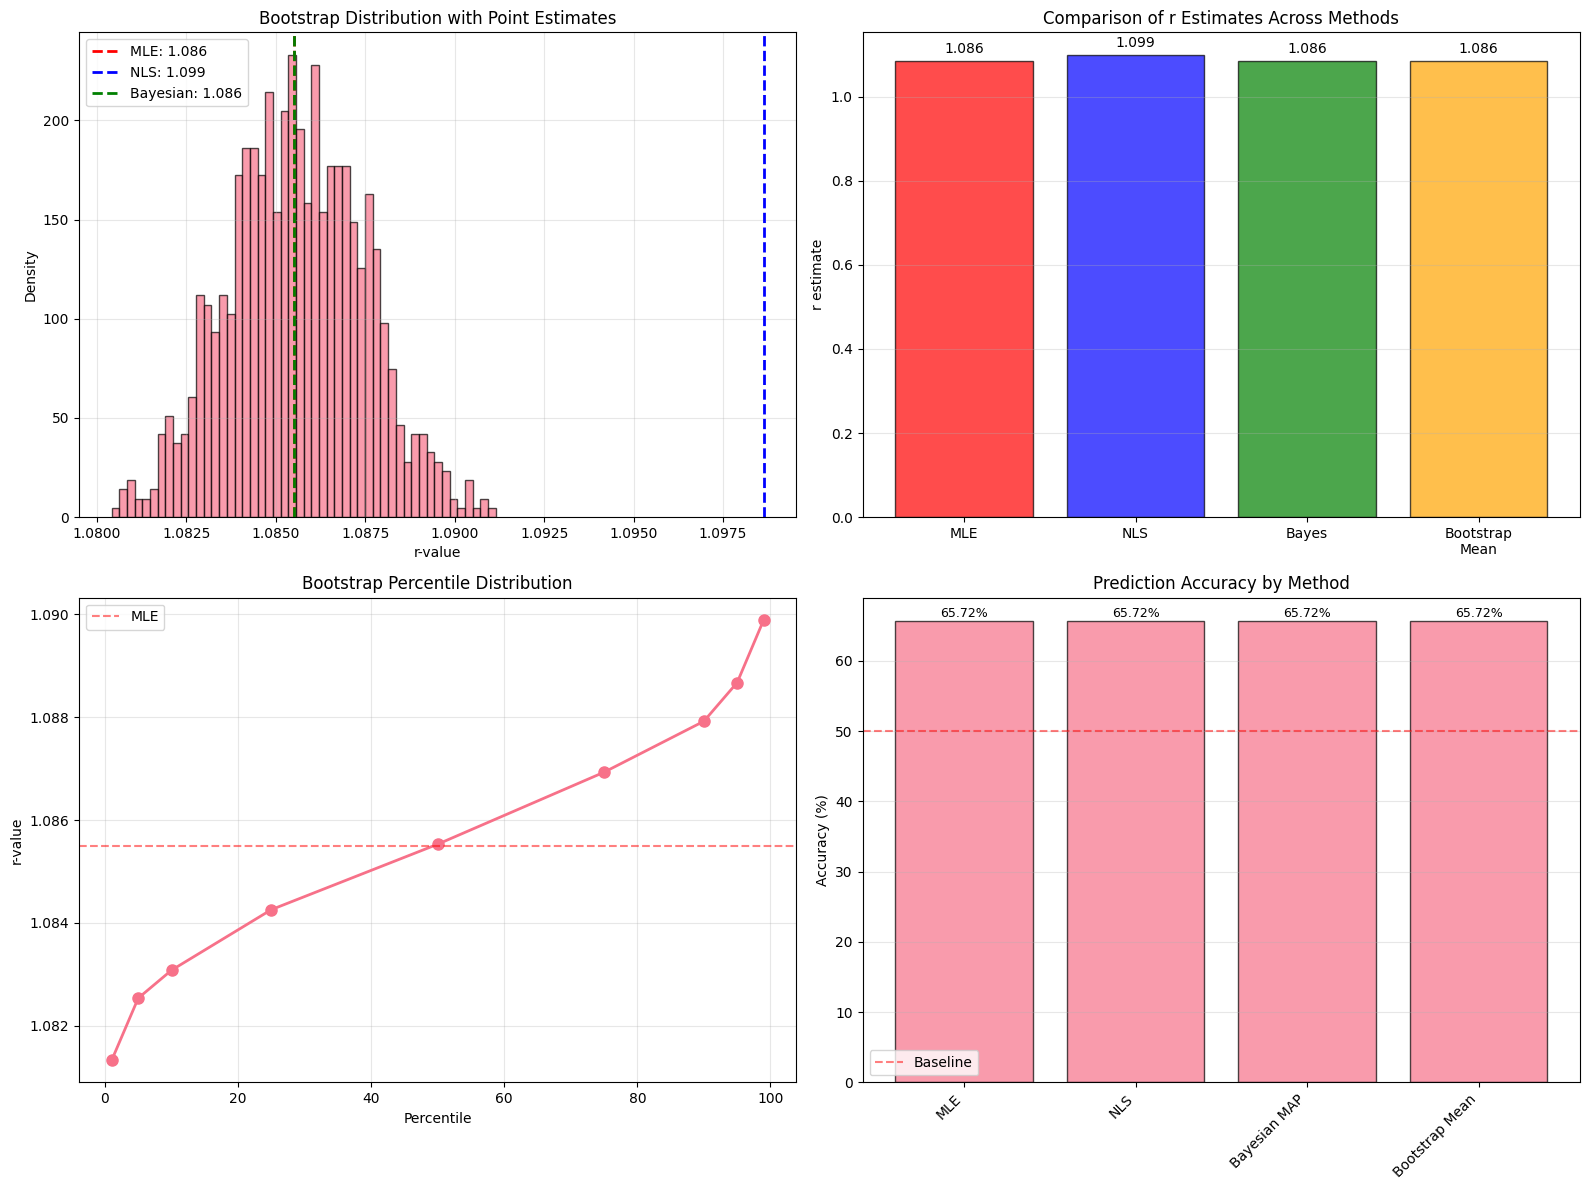

✅ Results stored in 'estimation_results' dictionary


In [10]:
# Estimate r using multiple methods: MLE, NLS, Bayesian, Bootstrap
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar, least_squares, minimize
from scipy.stats import beta
import warnings
warnings.filterwarnings('ignore')

# Prepare data - use CT vs T equipment
df_methods = equipment_df.copy()
df_methods = df_methods[(df_methods['ct_equipment'] > 0) & (df_methods['t_equipment'] > 0)].copy()
df_methods['ct_winner'] = df_methods['ct_winner'].astype(int)

x = df_methods['ct_equipment'].to_numpy(dtype=float)
y = df_methods['t_equipment'].to_numpy(dtype=float)
outcome = df_methods['ct_winner'].to_numpy(dtype=int)

log_x = np.log(x)
log_y = np.log(y)

print(f"Dataset: {len(x):,} rounds")
print(f"CT wins: {outcome.sum():,} ({outcome.mean()*100:.2f}%)")
print()

# ============================================================================
# METHOD 1: Maximum Likelihood Estimation (MLE)
# ============================================================================
print("=" * 70)
print("METHOD 1: MAXIMUM LIKELIHOOD ESTIMATION (MLE)")
print("=" * 70)

def neg_log_likelihood(r):
    if r <= 0:
        return np.inf
    logits = r * (log_x - log_y)
    p = 1.0 / (1.0 + np.exp(-logits))
    p = np.clip(p, 1e-9, 1 - 1e-9)
    ll = outcome * np.log(p) + (1 - outcome) * np.log(1 - p)
    return -ll.sum()

res_mle = minimize_scalar(neg_log_likelihood, bounds=(0.01, 5.0), method='bounded')
r_mle = res_mle.x
print(f"MLE estimate: r = {r_mle:.4f}")
print(f"Optimization success: {res_mle.success}")
print(f"Negative log-likelihood: {res_mle.fun:.2f}")
print()

# ============================================================================
# METHOD 2: Nonlinear Least Squares (NLS)
# ============================================================================
print("=" * 70)
print("METHOD 2: NONLINEAR LEAST SQUARES (NLS)")
print("=" * 70)

def csf_prediction(r, x_val, y_val):
    """Contest Success Function prediction"""
    return x_val**r / (x_val**r + y_val**r)

def residuals_nls(r_array):
    """Residuals for NLS: predicted - actual"""
    r = r_array[0]
    if r <= 0:
        return np.ones(len(x)) * 1e10
    pred = csf_prediction(r, x, y)
    return pred - outcome

# Use least_squares for bounded optimization
res_nls = least_squares(residuals_nls, [1.0], bounds=([0.01], [5.0]))
r_nls = res_nls.x[0]
rss = np.sum(res_nls.fun**2)
print(f"NLS estimate: r = {r_nls:.4f}")
print(f"Optimization success: {res_nls.success}")
print(f"Residual sum of squares: {rss:.2f}")
print()

# ============================================================================
# METHOD 3: Bayesian Estimation (MAP with Beta Prior)
# ============================================================================
print("=" * 70)
print("METHOD 3: BAYESIAN ESTIMATION (Maximum A Posteriori)")
print("=" * 70)

# Use a weakly informative prior: Beta(2, 2) scaled to reasonable r range
# This gives slight preference to r around 1.0 but allows wide range
def neg_log_posterior(r, alpha=2.0, beta_param=2.0):
    """Negative log posterior: -[log likelihood + log prior]"""
    if r <= 0 or r > 5.0:
        return np.inf
    
    # Log likelihood
    logits = r * (log_x - log_y)
    p = 1.0 / (1.0 + np.exp(-logits))
    p = np.clip(p, 1e-9, 1 - 1e-9)
    ll = outcome * np.log(p) + (1 - outcome) * np.log(1 - p)
    
    # Log prior: Beta distribution scaled to [0, 5]
    # Transform r to [0, 1] for Beta
    r_scaled = r / 5.0
    log_prior = (alpha - 1) * np.log(r_scaled) + (beta_param - 1) * np.log(1 - r_scaled)
    
    return -(ll.sum() + log_prior)

res_bayes = minimize_scalar(neg_log_posterior, bounds=(0.01, 5.0), method='bounded')
r_bayes = res_bayes.x
print(f"Bayesian MAP estimate: r = {r_bayes:.4f}")
print(f"Prior: Beta(2, 2) scaled to [0, 5]")
print(f"Optimization success: {res_bayes.success}")
print(f"Negative log posterior: {res_bayes.fun:.2f}")
print()

# ============================================================================
# METHOD 4: Bootstrap Confidence Intervals
# ============================================================================
print("=" * 70)
print("METHOD 4: BOOTSTRAP CONFIDENCE INTERVALS")
print("=" * 70)

n_bootstrap = 1000
bootstrap_r_values = []

np.random.seed(42)
print(f"Running {n_bootstrap} bootstrap iterations...")

for i in range(n_bootstrap):
    # Resample with replacement
    indices = np.random.choice(len(x), size=len(x), replace=True)
    x_boot = x[indices]
    y_boot = y[indices]
    outcome_boot = outcome[indices]
    
    log_x_boot = np.log(x_boot)
    log_y_boot = np.log(y_boot)
    
    # MLE on bootstrap sample
    def neg_ll_boot(r):
        if r <= 0:
            return np.inf
        logits = r * (log_x_boot - log_y_boot)
        p = 1.0 / (1.0 + np.exp(-logits))
        p = np.clip(p, 1e-9, 1 - 1e-9)
        ll = outcome_boot * np.log(p) + (1 - outcome_boot) * np.log(1 - p)
        return -ll.sum()
    
    try:
        res_boot = minimize_scalar(neg_ll_boot, bounds=(0.01, 5.0), method='bounded')
        if res_boot.success:
            bootstrap_r_values.append(res_boot.x)
    except:
        pass
    
    if (i + 1) % 200 == 0:
        print(f"  Completed {i + 1}/{n_bootstrap} iterations...")

bootstrap_r_values = np.array(bootstrap_r_values)
print(f"\nBootstrap iterations successful: {len(bootstrap_r_values)}/{n_bootstrap}")
print(f"Bootstrap mean: r = {bootstrap_r_values.mean():.4f}")
print(f"Bootstrap std: {bootstrap_r_values.std():.4f}")
print(f"95% CI: [{np.percentile(bootstrap_r_values, 2.5):.4f}, {np.percentile(bootstrap_r_values, 97.5):.4f}]")
print(f"90% CI: [{np.percentile(bootstrap_r_values, 5):.4f}, {np.percentile(bootstrap_r_values, 95):.4f}]")
print()

# ============================================================================
# COMPARISON SUMMARY
# ============================================================================
print("=" * 70)
print("COMPARISON OF ALL METHODS")
print("=" * 70)
results_df = pd.DataFrame({
    'Method': ['MLE', 'Nonlinear Least Squares', 'Bayesian MAP', 'Bootstrap Mean'],
    'r_estimate': [r_mle, r_nls, r_bayes, bootstrap_r_values.mean()],
    'Notes': [
        f'Neg LL: {res_mle.fun:.2f}',
        f'RSS: {rss:.2f}',
        f'Neg LP: {res_bayes.fun:.2f}',
        f'95% CI: [{np.percentile(bootstrap_r_values, 2.5):.4f}, {np.percentile(bootstrap_r_values, 97.5):.4f}]'
    ]
})
print(results_df.to_string(index=False))
print()

# Calculate prediction accuracy for each method
def evaluate_method(r_val, name):
    pred_prob = csf_prediction(r_val, x, y)
    pred_binary = (pred_prob >= 0.5).astype(int)
    accuracy = (pred_binary == outcome).mean()
    brier = np.mean((outcome - pred_prob) ** 2)
    return {'Method': name, 'r': r_val, 'Accuracy': accuracy, 'Brier Score': brier}

eval_results = [
    evaluate_method(r_mle, 'MLE'),
    evaluate_method(r_nls, 'NLS'),
    evaluate_method(r_bayes, 'Bayesian MAP'),
    evaluate_method(bootstrap_r_values.mean(), 'Bootstrap Mean')
]

eval_df = pd.DataFrame(eval_results)
print("Prediction Performance:")
print(eval_df.to_string(index=False))
print()

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bootstrap distribution
ax1.hist(bootstrap_r_values, bins=50, alpha=0.7, edgecolor='black', density=True)
ax1.axvline(r_mle, color='red', linestyle='--', linewidth=2, label=f'MLE: {r_mle:.3f}')
ax1.axvline(r_nls, color='blue', linestyle='--', linewidth=2, label=f'NLS: {r_nls:.3f}')
ax1.axvline(r_bayes, color='green', linestyle='--', linewidth=2, label=f'Bayesian: {r_bayes:.3f}')
ax1.set_xlabel('r-value')
ax1.set_ylabel('Density')
ax1.set_title('Bootstrap Distribution with Point Estimates')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Comparison of estimates
methods = ['MLE', 'NLS', 'Bayes', 'Bootstrap\nMean']
estimates = [r_mle, r_nls, r_bayes, bootstrap_r_values.mean()]
colors = ['red', 'blue', 'green', 'orange']
ax2.bar(methods, estimates, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('r estimate')
ax2.set_title('Comparison of r Estimates Across Methods')
ax2.grid(True, alpha=0.3, axis='y')
for i, (m, e) in enumerate(zip(methods, estimates)):
    ax2.text(i, e + 0.02, f'{e:.3f}', ha='center', fontsize=10)

# 3. Bootstrap confidence intervals
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
ci_values = [np.percentile(bootstrap_r_values, p) for p in percentiles]
ax3.plot(percentiles, ci_values, 'o-', linewidth=2, markersize=8)
ax3.axhline(r_mle, color='red', linestyle='--', alpha=0.5, label='MLE')
ax3.set_xlabel('Percentile')
ax3.set_ylabel('r-value')
ax3.set_title('Bootstrap Percentile Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Prediction accuracy comparison
methods_eval = eval_df['Method'].values
accuracies = eval_df['Accuracy'].values * 100
ax4.bar(range(len(methods_eval)), accuracies, alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(methods_eval)))
ax4.set_xticklabels(methods_eval, rotation=45, ha='right')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Prediction Accuracy by Method')
ax4.axhline(50, color='red', linestyle='--', alpha=0.5, label='Baseline')
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend()
for i, acc in enumerate(accuracies):
    ax4.text(i, acc + 0.5, f'{acc:.2f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Store results
estimation_results = {
    'r_mle': r_mle,
    'r_nls': r_nls,
    'r_bayes': r_bayes,
    'r_bootstrap_mean': bootstrap_r_values.mean(),
    'bootstrap_values': bootstrap_r_values,
    'bootstrap_ci_95': (np.percentile(bootstrap_r_values, 2.5), np.percentile(bootstrap_r_values, 97.5)),
    'evaluation': eval_df
}

print("✅ Results stored in 'estimation_results' dictionary")